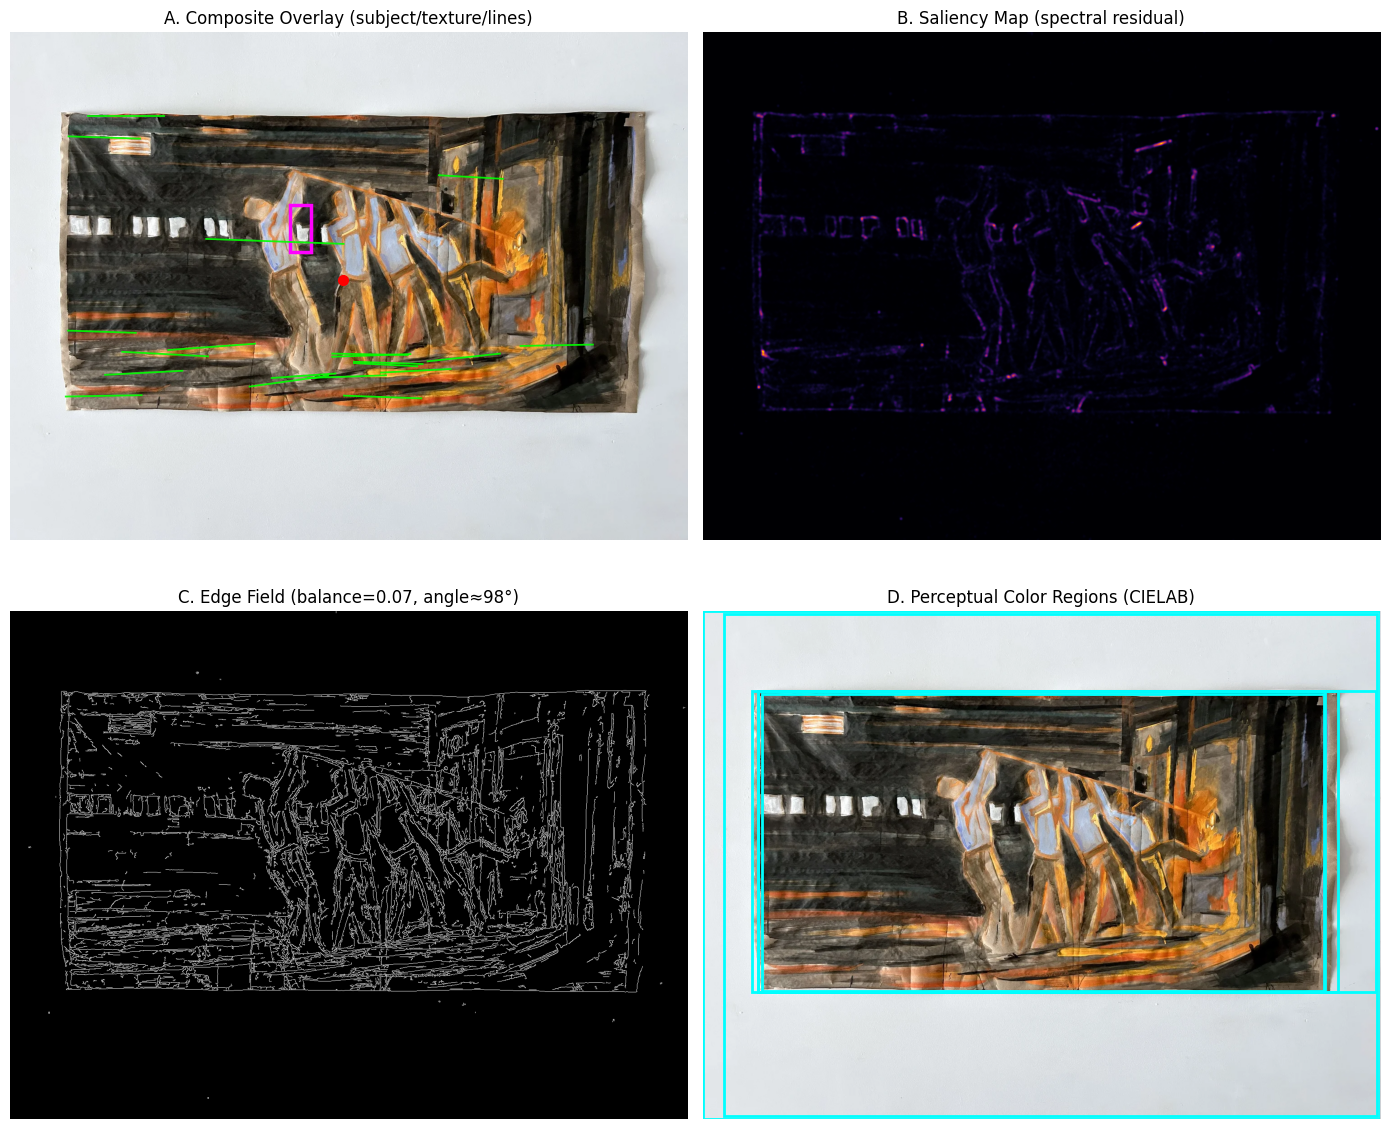


========== CURATORIAL SUMMARY ==========
Style (inferred): Abstract-Contemporary

— Micro —
Abstract-Contemporary tendencies; warm palette; strongly scaffolded composition. Surface is highly activated and directionally insistent; lighting shows chiaroscuro-inflected with expanded range.

— Deep —
The work presents a warm chromatic register with a palette variability of 29.4 (mean tone approx. RGB (np.int64(136), np.int64(117), np.int64(97))). The surface is highly activated, with directionally insistent orientation (Gabor anisotropy 87230586.909); Laplacian variance at 4713.0 indicates the degree of micro-contrast in the paint film. Compositionally the field is strongly scaffolded (≈132 linear trajectories), balanced in edge-weight, and organized around a focal attraction near (736, 549) (derived from spectral-residual saliency). Structural descriptors (area ratio 0.998, aspect 1.33, eccentricity 0.79) suggest the degree to which forms tend toward elongation or compactness. Illuminati

In [5]:
# ==========================================================
# High-Fidelity Artwork Analyzer v5 (Fully Local, Academic Tone)
# ==========================================================
# - Perceptual color clustering in CIELAB
# - Texture fidelity via Laplacian variance + multi-orientation Gabor energy
# - Composition via spectral-residual saliency (FFT), edge density, and Hough lines
# - Structural form via contour descriptors (area ratio, aspect, eccentricity)
# - Global illumination indices (lightness skew, local variance)
# - Rich, curatorial-style narrative tied directly to the measured features
#
# Requirements: opencv-python, pillow, numpy, matplotlib
# ==========================================================

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os, math
np.set_printoptions(suppress=True)

# ----------------------------
# Utilities
# ----------------------------
def load_rgb(image_path):
    img = Image.open(image_path).convert("RGB")
    return np.array(img), img.size  # (H,W,3), (W,H)

def clamp_bbox(x, y, w, h, W, H):
    x = max(0, int(x)); y = max(0, int(y))
    w = int(max(1, min(w, W - x))); h = int(max(1, min(h, H - y)))
    return x, y, w, h

def to_int_tuple_list(bboxes):
    out = []
    for b in bboxes:
        if len(b) == 4:
            out.append(tuple(int(v) for v in b))
    return out

# ----------------------------
# 1) Perceptual Color (CIELAB) with region bboxes
# ----------------------------
def analyze_color_lab(img_rgb, k=6, min_region_px_ratio=0.003):
    H, W = img_rgb.shape[:2]
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    Z = lab.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 0.3)
    K = max(2, int(k))
    _, labels, centers = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
    labels_2d = labels.reshape(H, W)
    centers = centers.astype(np.float32)

    # Dominant order by population
    counts = np.bincount(labels.flatten())
    order = np.argsort(-counts)
    centers = centers[order]
    # Convert back to approximate RGB for reporting
    centers_lab = centers.copy().reshape((-1,1,3)).astype(np.uint8)
    centers_rgb = cv2.cvtColor(centers_lab, cv2.COLOR_Lab2RGB).reshape((-1,3)).astype(int)

    # Create bboxes for clusters (only if sizable)
    min_px = int(min_region_px_ratio * H * W)
    bboxes, cluster_colors = [], []
    for idx, c_idx in enumerate(order):
        ys, xs = np.where(labels_2d == c_idx)
        if xs.size < min_px:
            continue
        x0, y0, x1, y1 = xs.min(), ys.min(), xs.max(), ys.max()
        bboxes.append((int(x0), int(y0), int(x1 - x0 + 1), int(y1 - y0 + 1)))
        cluster_colors.append(tuple(centers_rgb[idx].tolist()))

    # Palette variability (CIELAB std)
    color_variability = float(np.std(centers, axis=0).mean())
    return {
        "palette_rgb": cluster_colors,
        "bboxes": to_int_tuple_list(bboxes),
        "color_variability": color_variability
    }

# -------------------------
# 2) Texture Fidelity (Laplacian var + Gabor energy)
# -------------------------
def analyze_texture(img_rgb):
    """
    Measures texture fidelity using Laplacian variance and multi-angle Gabor filters.
    Works safely across OpenCV builds by normalizing image to 8-bit first.
    """

    # Convert to grayscale and normalize to 8-bit (prevents macOS Laplacian error)
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    gray_8u = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Laplacian variance (micro-contrast / fine texture)
    lap = cv2.Laplacian(gray_8u, cv2.CV_64F, ksize=3)
    lap_var = float(lap.var())

    # Multi-orientation Gabor energy (directionality / brushstroke)
    orientations = [0, 30, 60, 90, 120, 150]
    wavelength = max(4, min(gray.shape) // 40)
    gabor_energies = []
    for theta_deg in orientations:
        theta = np.deg2rad(theta_deg)
        kern = cv2.getGaborKernel(
            ksize=(31, 31),
            sigma=6.0,
            theta=theta,
            lambd=wavelength,
            gamma=0.5,
            psi=0
        )
        resp = cv2.filter2D(gray_8u, cv2.CV_32F, kern)
        gabor_energies.append(float(np.mean(resp ** 2)))

    gabor_mean = float(np.mean(gabor_energies))
    gabor_anisotropy = float(np.std(gabor_energies))  # directional emphasis

    # High-texture regions via Laplacian magnitude
    mag = np.abs(lap)
    thr = np.percentile(mag, 97.5)
    mask = (mag >= thr).astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    H, W = gray.shape
    boxes = []
    for c in contours:
        if cv2.contourArea(c) < (H * W * 0.001):
            continue
        x, y, w, h = cv2.boundingRect(c)
        boxes.append((int(x), int(y), int(w), int(h)))

    # Sort and keep up to 5 largest texture zones
    boxes = sorted(boxes, key=lambda b: b[2] * b[3], reverse=True)[:5]

    return {
        "laplacian_variance": lap_var,
        "gabor_mean_energy": gabor_mean,
        "gabor_anisotropy": gabor_anisotropy,
        "texture_bboxes": boxes
    }


# ----------------------------
# 3) Spectral-Residual Saliency (pure NumPy, no cv2.saliency)
# ----------------------------
def spectral_residual_saliency(gray_f32):
    # Based on Hou & Zhang spectral residual approach
    eps = 1e-8
    H, W = gray_f32.shape
    # FFT
    fft = np.fft.fft2(gray_f32)
    amp = np.abs(fft)
    log_amp = np.log(amp + eps)
    phase = np.angle(fft)
    # Average log amplitude via local smoothing in freq domain
    avg_log_amp = cv2.blur(log_amp, (3,3))
    spectral_residual = log_amp - avg_log_amp
    # Reconstruct
    saliency = np.abs(np.fft.ifft2(np.exp(spectral_residual + 1j*phase)))**2
    saliency = cv2.GaussianBlur(saliency, (9,9), 2.0)
    # Normalize 0-255
    sal_norm = saliency - saliency.min()
    if sal_norm.max() > 0:
        sal_norm = sal_norm / sal_norm.max()
    return (sal_norm * 255).astype(np.uint8)

def analyze_saliency_and_subject(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
    sal = spectral_residual_saliency(gray)
    # Saliency threshold via Otsu
    _, th = cv2.threshold(sal, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    H, W = gray.shape
    if contours:
        c = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        bbox = clamp_bbox(x,y,w,h,W,H)
    else:
        bbox = clamp_bbox(W//4, H//4, W//2, H//2, W, H)

    # Focal point as saliency-weighted centroid
    Y, X = np.indices((H,W))
    wts = sal.astype(np.float32) + 1.0
    cx = float((X*wts).sum() / wts.sum())
    cy = float((Y*wts).sum() / wts.sum())

    return {
        "saliency_map": sal,
        "subject_bbox": (int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])),
        "focal_point": (int(cx), int(cy))
    }

# ----------------------------
# 4) Composition: edges, Hough lines, balance index
# ----------------------------
def analyze_composition(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    H, W = gray.shape
    edges = cv2.Canny(gray, 100, 200)
    linesP = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=120,
                             minLineLength=min(W,H)//8, maxLineGap=20)
    lines = []
    if linesP is not None:
        for l in linesP[:,0,:]:
            x1,y1,x2,y2 = [int(v) for v in l]
            lines.append((x1,y1,x2,y2))

    # Edge-weighted left/right balance
    left_weight = edges[:, :W//2].sum()
    right_weight = edges[:, W//2:].sum()
    balance = (right_weight - left_weight) / (left_weight + right_weight + 1e-6)

    # Dominant orientation from Sobel angle histogram
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    angles = (np.rad2deg(np.arctan2(gy, gx)) + 180.0) % 180.0
    mag = np.sqrt(gx**2 + gy**2)
    # Weight histogram by magnitude
    hist, bins = np.histogram(angles.flatten(), bins=12, range=(0,180), weights=mag.flatten())
    dominant_angle = float(0.5*(bins[np.argmax(hist)] + bins[np.argmax(hist)+1]))

    return {
        "edges": edges,
        "lines": lines,
        "edge_balance": float(balance),
        "dominant_angle_deg": dominant_angle
    }

# ----------------------------
# 5) Structural shape descriptors
# ----------------------------
def analyze_structure(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    H, W = gray.shape
    # Binary via adaptive threshold for robustness
    th = cv2.adaptiveThreshold((gray*0+gray).astype(np.uint8), 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, 5)
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return {"area_ratio": 0.0, "aspect_ratio": 1.0, "eccentricity": 0.0}

    c = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(c)
    x,y,w,h = cv2.boundingRect(c)
    # Area ratio (coverage)
    area_ratio = float(area / (W*H))
    # Aspect of bbox
    aspect_ratio = float(w / (h + 1e-6))
    # Eccentricity via ellipse (if possible)
    ecc = 0.0
    if len(c) >= 5:
        (cx,cy),(MA,ma),angle = cv2.fitEllipse(c)
        a = max(MA, ma) / 2.0
        b = min(MA, ma) / 2.0
        if a > 0:
            ecc = float(np.sqrt(max(0.0, 1.0 - (b*b)/(a*a))))

    return {
        "area_ratio": area_ratio,
        "aspect_ratio": aspect_ratio,
        "eccentricity": ecc
    }

# ----------------------------
# 6) Illumination / Tonal map (lightness skew, local variance)
# ----------------------------
def analyze_illumination(img_rgb):
    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    L = lab[:,:,0].astype(np.float32)  # 0..255
    # Skewness approximation (third standardized moment)
    mu = L.mean(); sigma = L.std() + 1e-6
    skew = float((((L - mu)/sigma)**3).mean())
    # Local variance (texture-like but strictly lightness)
    local = cv2.GaussianBlur(L, (0,0), 3)
    local_var = float(((L - local)**2).mean())
    return {"lightness_skew": skew, "lightness_local_var": local_var}

# ----------------------------
# 7) Synthesis: academic narrative
# ----------------------------
def academic_report(metrics):
    """
    Compose a curatorial note grounded in measured features.
    """
    # Palette summary
    palette = metrics["color"]["palette_rgb"]
    color_var = metrics["color"]["color_variability"]
    avg = tuple(np.array(palette).mean(axis=0).astype(int)) if palette else (0,0,0)
    temp = "warm" if avg[0] > avg[2] + 10 else "cool" if avg[2] > avg[0] + 10 else "neutral"

    # Texture summary
    lapv = metrics["texture"]["laplacian_variance"]
    gmean = metrics["texture"]["gabor_mean_energy"]
    ganiso = metrics["texture"]["gabor_anisotropy"]

    # Composition summary
    n_lines = len(metrics["composition"]["lines"])
    angle = metrics["composition"]["dominant_angle_deg"]
    balance = metrics["composition"]["edge_balance"]
    focal = metrics["saliency"]["focal_point"]

    # Structure summary
    area_ratio = metrics["structure"]["area_ratio"]
    aspect = metrics["structure"]["aspect_ratio"]
    ecc = metrics["structure"]["eccentricity"]

    # Illumination
    skew = metrics["illumination"]["lightness_skew"]
    lvar = metrics["illumination"]["lightness_local_var"]

    # Qualifiers from metrics
    texture_qual = ("subtly modulated" if lapv < 15 else "articulated" if lapv < 40
                    else "densely worked" if lapv < 85 else "highly activated")
    direction_qual = ("diffuse" if ganiso < 0.02 else "softly oriented" if ganiso < 0.06
                      else "directionally insistent")
    line_qual = ("largely unstructured" if n_lines < 6 else
                 "discretely structured" if n_lines < 20 else
                 "strongly scaffolded")
    balance_qual = ("left-weighted" if balance < -0.12 else
                    "balanced" if abs(balance) <= 0.12 else
                    "right-weighted")
    light_qual = ("compressed range" if lvar < 30 else "moderate range" if lvar < 90 else "expanded range")
    chiaroscuro_qual = ("flattened" if skew > -0.2 and skew < 0.2 else
                        "chiaroscuro-inflected" if skew < -0.2 else
                        "high-key luminous")

    # Style inference (transparent): weighted voting from metrics
    score = (lapv * 0.25) + (ganiso * 600 * 0.15) + (n_lines * 0.1) + (abs(balance) * 40 * 0.1) + (color_var * 0.25) + (abs(skew) * 8 * 0.15)
    if score < 18: style = "Minimalist"
    elif score < 28: style = "Realist"
    elif score < 40: style = "Impressionist"
    elif score < 55: style = "Expressionist"
    elif score < 70: style = "Surrealist"
    else: style = "Abstract-Contemporary"

    # MICRO (compact)
    micro = (
        f"{style} tendencies; {temp} palette; {line_qual} composition. "
        f"Surface is {texture_qual} and {direction_qual}; lighting shows {chiaroscuro_qual} with {light_qual}."
    )

    # DEEP (curatorial)
    deep = (
        f"The work presents a {temp} chromatic register with a palette variability of {color_var:.1f} "
        f"(mean tone approx. RGB {avg}). The surface is {texture_qual}, with "
        f"{direction_qual} orientation (Gabor anisotropy {ganiso:.3f}); "
        f"Laplacian variance at {lapv:.1f} indicates the degree of micro-contrast in the paint film. "
        f"Compositionally the field is {line_qual} (≈{n_lines} linear trajectories), "
        f"{balance_qual} in edge-weight, and organized around a focal attraction near {tuple(int(v) for v in focal)} "
        f"(derived from spectral-residual saliency). Structural descriptors (area ratio {area_ratio:.3f}, "
        f"aspect {aspect:.2f}, eccentricity {ecc:.2f}) suggest the degree to which forms tend toward "
        f"elongation or compactness. Illumination exhibits {chiaroscuro_qual} behavior "
        f"(lightness skew {skew:.2f}) within a {light_qual}. "
        f"Taken together, the measured indices situate the work within a {style.lower()} rhetoric."
    )

    return style, micro, deep

# ----------------------------
# 8) Master routine
# ----------------------------
def analyze_artwork_high_fidelity(image_path, show_overlays=True, save_summary=True):
    img_rgb, (W, H) = load_rgb(image_path)
    H_img, W_img = img_rgb.shape[:2]

    # COLOR
    color = analyze_color_lab(img_rgb, k=6)

    # TEXTURE
    texture = analyze_texture(img_rgb)

    # SALIENCY / SUBJECT
    saliency = analyze_saliency_and_subject(img_rgb)

    # COMPOSITION
    composition = analyze_composition(img_rgb)

    # STRUCTURE
    structure = analyze_structure(img_rgb)

    # ILLUMINATION
    illumination = analyze_illumination(img_rgb)

    metrics = {
        "color": color,
        "texture": texture,
        "saliency": saliency,
        "composition": composition,
        "structure": structure,
        "illumination": illumination
    }

    style, micro, deep = academic_report(metrics)

    # ---------------- Visual Overlays ----------------
    if show_overlays:
        fig = plt.figure(figsize=(14, 12))

        # Panel 1: Original + composite overlays
        ax1 = fig.add_subplot(2,2,1)
        ax1.imshow(img_rgb)
        ax1.set_title("A. Composite Overlay (subject/texture/lines)")
        # Subject bbox (magenta)
        sx,sy,sw,sh = saliency["subject_bbox"]
        ax1.add_patch(patches.Rectangle((sx,sy), sw,sh, linewidth=2.5, edgecolor='magenta', facecolor='none', label='Subject'))
        # Texture boxes (yellow)
        for (x,y,w,h) in texture["texture_bboxes"]:
            ax1.add_patch(patches.Rectangle((x,y), w,h, linewidth=2, edgecolor='yellow', facecolor='none'))
        # Hough lines (lime)
        for (x1,y1,x2,y2) in composition["lines"][:20]:
            ax1.plot([x1,x2],[y1,y2], color='lime', linewidth=1.3, alpha=0.9)
        # Focal point (red)
        fx, fy = saliency["focal_point"]
        ax1.plot(fx, fy, 'ro', markersize=7)
        ax1.axis('off')

        # Panel 2: Saliency map
        ax2 = fig.add_subplot(2,2,2)
        ax2.imshow(saliency["saliency_map"], cmap="inferno")
        ax2.set_title("B. Saliency Map (spectral residual)")
        ax2.axis('off')

        # Panel 3: Edge density
        ax3 = fig.add_subplot(2,2,3)
        ax3.imshow(composition["edges"], cmap="gray")
        ax3.set_title(f"C. Edge Field (balance={composition['edge_balance']:.2f}, angle≈{composition['dominant_angle_deg']:.0f}°)")
        ax3.axis('off')

        # Panel 4: Color clusters
        ax4 = fig.add_subplot(2,2,4)
        ax4.imshow(img_rgb)
        for (x,y,w,h) in color["bboxes"]:
            ax4.add_patch(patches.Rectangle((x,y), w,h, linewidth=2, edgecolor='cyan', facecolor='none'))
        ax4.set_title("D. Perceptual Color Regions (CIELAB)")
        ax4.axis('off')

        plt.tight_layout()
        plt.show()

    # ---------------- Print Report ----------------
    print("\n========== CURATORIAL SUMMARY ==========")
    print("Style (inferred):", style)
    print("\n— Micro —")
    print(micro)
    print("\n— Deep —")
    print(deep)

    # Metrics digest
    print("\n========== METRICS DIGEST ==========")
    print("Palette (top RGB centers):", color["palette_rgb"])
    print("Color variability (CIELAB mean std):", f"{color['color_variability']:.2f}")
    print("Texture: Laplacian var", f"{texture['laplacian_variance']:.2f}",
          "| Gabor mean", f"{texture['gabor_mean_energy']:.2f}",
          "| Gabor anisotropy", f"{texture['gabor_anisotropy']:.3f}")
    print("Texture regions:", texture["texture_bboxes"])
    print("Subject bbox:", saliency["subject_bbox"], "| Focal:", saliency["focal_point"])
    print("Edges: lines", len(composition["lines"]),
          "| Balance", f"{composition['edge_balance']:.2f}",
          "| Dominant angle", f"{composition['dominant_angle_deg']:.0f}°")
    print("Structure: area_ratio", f"{structure['area_ratio']:.3f}",
          "| aspect", f"{structure['aspect_ratio']:.2f}",
          "| eccentricity", f"{structure['eccentricity']:.2f}")
    print("Illumination: lightness skew", f"{illumination['lightness_skew']:.2f}",
          "| local variance", f"{illumination['lightness_local_var']:.2f}")

    # Optional save
    if save_summary:
        base, ext = os.path.splitext(image_path)
        out_txt = base + "_v5_summary.txt"
        with open(out_txt, "w") as f:
            f.write("=== High-Fidelity Artwork Analyzer v5 ===\n")
            f.write(f"File: {os.path.basename(image_path)}\n\n")
            f.write(f"Style (inferred): {style}\n\n")
            f.write("Micro:\n" + micro + "\n\n")
            f.write("Deep:\n" + deep + "\n\n")
            f.write("---- Metrics ----\n")
            f.write(f"Palette RGB centers: {metrics['color']['palette_rgb']}\n")
            f.write(f"Color variability: {metrics['color']['color_variability']:.2f}\n")
            f.write(f"Laplacian variance: {metrics['texture']['laplacian_variance']:.2f}\n")
            f.write(f"Gabor mean energy: {metrics['texture']['gabor_mean_energy']:.2f}\n")
            f.write(f"Gabor anisotropy: {metrics['texture']['gabor_anisotropy']:.3f}\n")
            f.write(f"Texture regions: {metrics['texture']['texture_bboxes']}\n")
            f.write(f"Subject bbox: {metrics['saliency']['subject_bbox']}\n")
            f.write(f"Focal point: {metrics['saliency']['focal_point']}\n")
            f.write(f"Lines: {len(metrics['composition']['lines'])}\n")
            f.write(f"Edge balance: {metrics['composition']['edge_balance']:.2f}\n")
            f.write(f"Dominant angle: {metrics['composition']['dominant_angle_deg']:.0f}°\n")
            f.write(f"Area ratio: {metrics['structure']['area_ratio']:.3f}\n")
            f.write(f"Aspect ratio: {metrics['structure']['aspect_ratio']:.2f}\n")
            f.write(f"Eccentricity: {metrics['structure']['eccentricity']:.2f}\n")
            f.write(f"Lightness skew: {metrics['illumination']['lightness_skew']:.2f}\n")
            f.write(f"Lightness local variance: {metrics['illumination']['lightness_local_var']:.2f}\n")
        print(f"\n📄 Saved curatorial summary: {out_txt}")

    return {"style": style, "micro": micro, "deep": deep, "metrics": metrics}

# ----------------------------
# Run (set your image path)
# ----------------------------
if __name__ == "__main__":
    # Replace with your artwork path:
    IMAGE_PATH = "/Users/alievanayasso/Documents/SlowMA/Corey bonnet zynka.webp"
    analyze_artwork_high_fidelity(IMAGE_PATH, show_overlays=True, save_summary=True)
